In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

In [2]:
DATASETS = [
    {
        'filepath': 'datasets/ethylene_CO.txt',
        'mixture_name': 'Etileno_CO',
        'gas1_name': 'CO',
        'gas2_name': 'Etileno'
    },
    {
        'filepath': 'datasets/ethylene_methane.txt',
        'mixture_name': 'Etileno_Metano',
        'gas1_name': 'CH4',
        'gas2_name': 'Etileno'
    }
]

# Parámetros comunes para ambos análisis
PARAMS = {
    # Preprocesamiento
    'downsample_factor': 100,  # De 100 Hz a 1 Hz
    'window_size': 5,          # Ventana de suavizado
    
    # Feature Engineering
    'lag_steps': [1, 2, 5],           # Pasos de retardo
    'window_sizes': [5, 10],          # Tamaños de ventana para agregados
    
    # Train/Val/Test Split
    'test_size': 0.2,   # 20% para test
    'val_size': 0.1,    # 10% para validación
    
    # Detección de Anomalías
    'contamination': 0.05,  # 5% de anomalías esperadas
    
    # Robustez
    'failure_rates': [0.1, 0.2, 0.3],  # Tasas de fallo a probar
    'n_trials': 5,                      # Número de pruebas por tasa
    
    # Directorios
    'output_base_dir': 'visualizations',
    'report_base_name': 'reporte'
}

print("\n✓ Configuración establecida:")
print(f"\n  Datasets a analizar:")
for i, ds in enumerate(DATASETS, 1):
    print(f"    {i}. {ds['mixture_name']}: {ds['gas1_name']} + {ds['gas2_name']}")

print(f"\n  Parámetros comunes:")
print(f"    - Downsampling: {PARAMS['downsample_factor']}x (100 Hz → {100/PARAMS['downsample_factor']} Hz)")
print(f"    - Lags: {PARAMS['lag_steps']}")
print(f"    - Ventanas agregados: {PARAMS['window_sizes']}")
print(f"    - Split: Train={(1-PARAMS['test_size']-PARAMS['val_size'])*100:.0f}%, Val={PARAMS['val_size']*100:.0f}%, Test={PARAMS['test_size']*100:.0f}%")
print(f"    - Tasas de fallo: {[f'{f*100:.0f}%' for f in PARAMS['failure_rates']]}")

print("\n" + "="*80)


✓ Configuración establecida:

  Datasets a analizar:
    1. Etileno_CO: CO + Etileno
    2. Etileno_Metano: CH4 + Etileno

  Parámetros comunes:
    - Downsampling: 100x (100 Hz → 1.0 Hz)
    - Lags: [1, 2, 5]
    - Ventanas agregados: [5, 10]
    - Split: Train=70%, Val=10%, Test=20%
    - Tasas de fallo: ['10%', '20%', '30%']



In [ ]:
# ============================================================================
# CELDA 3: CARGAR AMBOS DATASETS (SIN ELIMINAR FILAS)
# ============================================================================

print("\n[1] CARGANDO DATASETS")
print("="*80)

# Diccionario para almacenar todos los datos
data_all = {}

# Definir nombres de columnas (común para ambos datasets)
columns = ['Time_s', 'CO_or_CH4_ppm', 'Ethylene_ppm'] + [f'Sensor_{i}' for i in range(1, 17)]

# Cargar cada dataset
for dataset_info in DATASETS:
    filepath = dataset_info['filepath']
    mixture_name = dataset_info['mixture_name']
    
    print(f"\n📁 Cargando: {mixture_name}")
    print("-" * 80)
    
    # Verificar si el archivo existe
    if not os.path.exists(filepath):
        print(f"  ⚠ ADVERTENCIA: Archivo no encontrado: {filepath}")
        print(f"  Descárgalo de: https://archive.ics.uci.edu/dataset/322")
        continue
    
    # Cargar archivo línea por línea (método más robusto)
    print(f"  → Leyendo archivo...")
    data_rows = []
    
    with open(filepath, 'r') as f:
        for line_num, line in enumerate(f, 1):
            # Dividir la línea por espacios en blanco
            values = line.strip().split()
            
            # Verificar que tiene 19 columnas
            if len(values) == 19:
                # Convertir a float
                try:
                    row = [float(v) for v in values]
                    data_rows.append(row)
                except ValueError:
                    # Si hay error de conversión, mostrar advertencia pero continuar
                    print(f"    ⚠ Línea {line_num}: No se pudo convertir - {line.strip()[:50]}...")
            else:
                # Línea con número incorrecto de columnas
                if line.strip():  # Solo advertir si no es línea vacía
                    print(f"    ⚠ Línea {line_num}: {len(values)} columnas (esperadas 19)")
    
    # Crear DataFrame directamente desde los datos leídos
    df = pd.DataFrame(data_rows, columns=columns)
    
    print(f"  ✓ Datos cargados exitosamente")
    print(f"    - Registros: {len(df):,}")
    print(f"    - Columnas: {len(df.columns)}")
    print(f"    - Duración: {df['Time_s'].max():.0f} segundos ({df['Time_s'].max()/3600:.2f} horas)")
    print(f"    - Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"    - Valores faltantes: {df.isnull().sum().sum()}")
    print(f"    - Tipo de datos: {df.dtypes[0]} (todas las columnas)")
    
    # Guardar en diccionario
    data_all[mixture_name] = {
        'df': df,
        'info': dataset_info
    }

print(f"\n✓ Total de datasets cargados: {len(data_all)}")
print("="*80)

# Mostrar comparación de tamaños
if len(data_all) == 2:
    print("\n📊 Comparación de datasets:")
    print("-" * 80)
    for name, data in data_all.items():
        print(f"  {name:20s}: {len(data['df']):>10,} registros, {data['df'].memory_usage(deep=True).sum() / 1024**2:>6.2f} MB")

# Mostrar muestra de datos
print("\n📋 Muestra de datos del primer dataset:")
print("-" * 80)
if len(data_all) > 0:
    first_dataset = list(data_all.values())[0]['df']
    print(first_dataset.head(10))
    print("\n📊 Estadísticas básicas:")
    print(first_dataset.describe())

ANÁLISIS EXPLORATORIO COMPARATIVO
Etileno_CO
Estadísticas de concentraciones:
    CO:
      Media: 127.62 ppm
      Std: 160.78 ppm
      Min-Max: [0, 533] ppm
    Etileno:
      Media: 5.32 ppm
      Std: 5.62 ppm
      Min-Max: [0, 20] ppm

  Transiciones detectadas:
    CO: 192
    Etileno: 184

  Regímenes de operación:
    Gas puro: 77.03%
    Mezcla: 22.97%

  Análisis de sensores:
    Sensores con posible flatline (>1%): 4/16
Etileno_Metano
Estadísticas de concentraciones:
    CH4:
      Media: 58.09 ppm
      Std: 76.64 ppm
      Min-Max: [0, 297] ppm
    Etileno:
      Media: 4.37 ppm
      Std: 5.52 ppm
      Min-Max: [0, 20] ppm

  Transiciones detectadas:
    CH4: 184
    Etileno: 171

  Regímenes de operación:
    Gas puro: 79.69%
    Mezcla: 20.31%

  Análisis de sensores:
    Sensores con posible flatline (>1%): 7/16

  Generando visualizaciones comparativas...


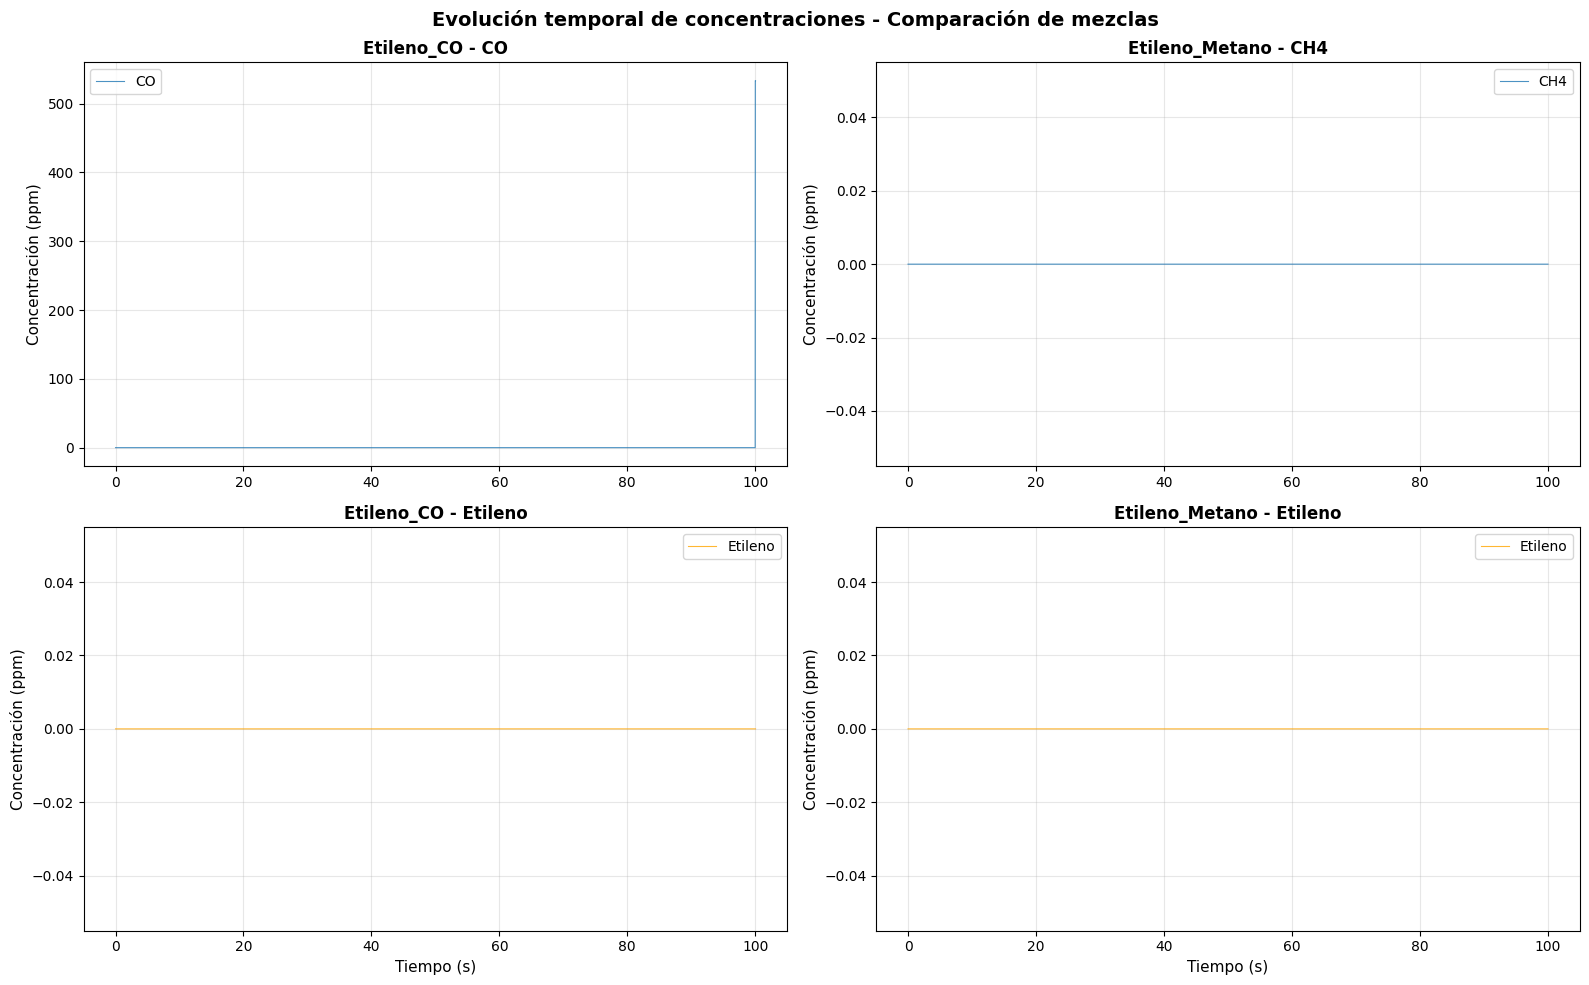

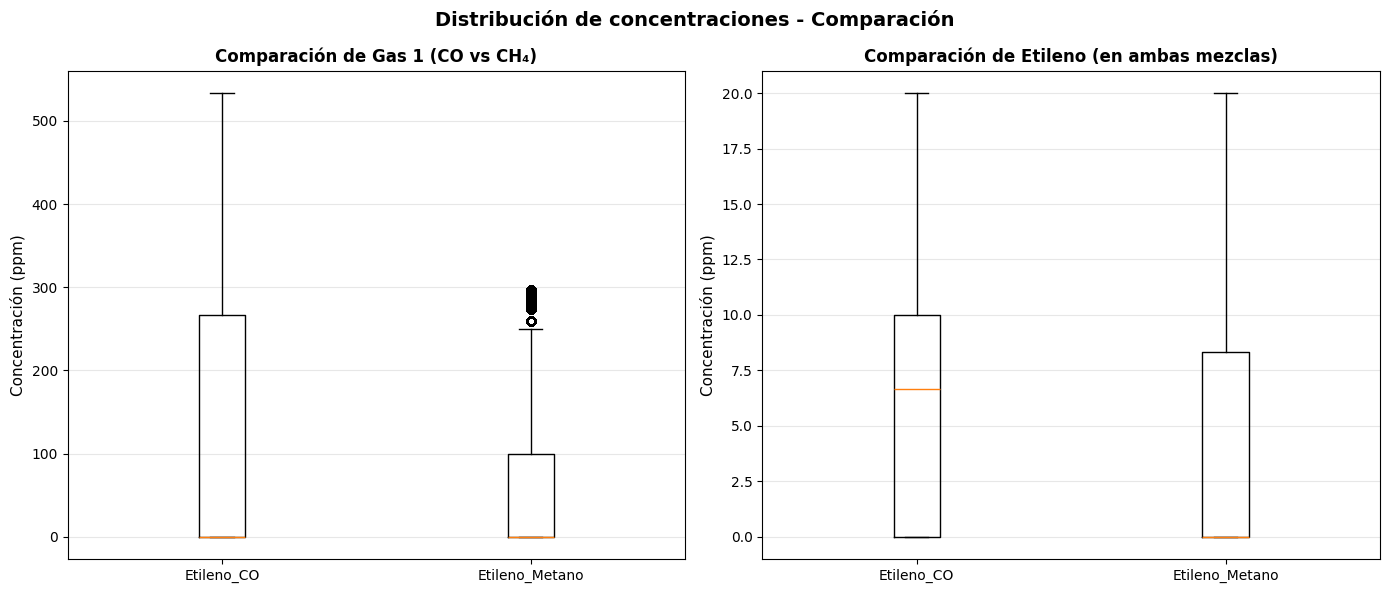

✓ Análisis exploratorio comparativo completado


In [8]:
print("ANÁLISIS EXPLORATORIO COMPARATIVO")


# Análisis individual de cada dataset
for mixture_name, data in data_all.items():
    df = data['df']
    gas1_name = data['info']['gas1_name']
    gas2_name = data['info']['gas2_name']
    
    print(f"{mixture_name}")

    
    # Estadísticas de concentraciones
    print(f"Estadísticas de concentraciones:")
    print(f"    {gas1_name}:")
    print(f"      Media: {df['CO_or_CH4_ppm'].mean():.2f} ppm")
    print(f"      Std: {df['CO_or_CH4_ppm'].std():.2f} ppm")
    print(f"      Min-Max: [{df['CO_or_CH4_ppm'].min():.0f}, {df['CO_or_CH4_ppm'].max():.0f}] ppm")
    print(f"    {gas2_name}:")
    print(f"      Media: {df['Ethylene_ppm'].mean():.2f} ppm")
    print(f"      Std: {df['Ethylene_ppm'].std():.2f} ppm")
    print(f"      Min-Max: [{df['Ethylene_ppm'].min():.0f}, {df['Ethylene_ppm'].max():.0f}] ppm")
    
    # Transiciones
    transitions_gas1 = (df['CO_or_CH4_ppm'].diff() != 0).sum()
    transitions_gas2 = (df['Ethylene_ppm'].diff() != 0).sum()
    print(f"\n  Transiciones detectadas:")
    print(f"    {gas1_name}: {transitions_gas1}")
    print(f"    {gas2_name}: {transitions_gas2}")
    
    # Gas puro vs mezcla
    gas_pure_mask = (df['CO_or_CH4_ppm'] == 0) | (df['Ethylene_ppm'] == 0)
    gas_pure_pct = (gas_pure_mask.sum() / len(df)) * 100
    print(f"\n  Regímenes de operación:")
    print(f"    Gas puro: {gas_pure_pct:.2f}%")
    print(f"    Mezcla: {100-gas_pure_pct:.2f}%")
    
    # Análisis de sensores (resumen)
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    flatlines = 0
    for col in sensor_cols:
        changes = (df[col].diff() != 0).sum()
        if (1 - changes/len(df)) * 100 > 1:  # >1% flatline
            flatlines += 1
    print(f"\n  Análisis de sensores:")
    print(f"    Sensores con posible flatline (>1%): {flatlines}/{len(sensor_cols)}")

# Visualización comparativa
print(f"\n  Generando visualizaciones comparativas...")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (mixture_name, data) in enumerate(data_all.items()):
    df = data['df']
    gas1_name = data['info']['gas1_name']
    gas2_name = data['info']['gas2_name']
    
    # Usar subset para visualización
    time_subset = df['Time_s'][:10000]
    
    # Gas 1
    axes[0, idx].plot(time_subset, df['CO_or_CH4_ppm'][:10000], 
                     linewidth=0.8, alpha=0.8, label=gas1_name)
    axes[0, idx].set_ylabel('Concentración (ppm)', fontsize=11)
    axes[0, idx].set_title(f'{mixture_name} - {gas1_name}', fontsize=12, fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Gas 2
    axes[1, idx].plot(time_subset, df['Ethylene_ppm'][:10000], 
                     linewidth=0.8, alpha=0.8, color='orange', label=gas2_name)
    axes[1, idx].set_xlabel('Tiempo (s)', fontsize=11)
    axes[1, idx].set_ylabel('Concentración (ppm)', fontsize=11)
    axes[1, idx].set_title(f'{mixture_name} - {gas2_name}', fontsize=12, fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.suptitle('Evolución temporal de concentraciones - Comparación de mezclas', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Boxplot comparativo de concentraciones
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Preparar datos para boxplot
gas1_data = []
gas2_data = []
labels = []

for mixture_name, data in data_all.items():
    df = data['df']
    gas1_data.append(df['CO_or_CH4_ppm'])
    gas2_data.append(df['Ethylene_ppm'])
    labels.append(mixture_name)

# Gas 1
axes[0].boxplot(gas1_data, labels=labels)
axes[0].set_ylabel('Concentración (ppm)', fontsize=11)
axes[0].set_title('Comparación de Gas 1 (CO vs CH₄)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Gas 2 (Etileno en ambos)
axes[1].boxplot(gas2_data, labels=labels)
axes[1].set_ylabel('Concentración (ppm)', fontsize=11)
axes[1].set_title('Comparación de Etileno (en ambas mezclas)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribución de concentraciones - Comparación', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✓ Análisis exploratorio comparativo completado")



[3] PREPROCESAMIENTO

📝 Procesando: Etileno_CO
--------------------------------------------------------------------------------
  ✓ Downsampling: 4,208,261 → 42,083 registros
    Reducción: 99.0%
  ✓ Sensores convertidos a kΩ
  ✓ Suavizado aplicado (ventana=5)

📝 Procesando: Etileno_Metano
--------------------------------------------------------------------------------
  ✓ Downsampling: 4,178,504 → 41,786 registros
    Reducción: 99.0%
  ✓ Sensores convertidos a kΩ
  ✓ Suavizado aplicado (ventana=5)

✓ Preprocesamiento completado para 2 datasets

  Visualización del efecto del preprocesamiento:


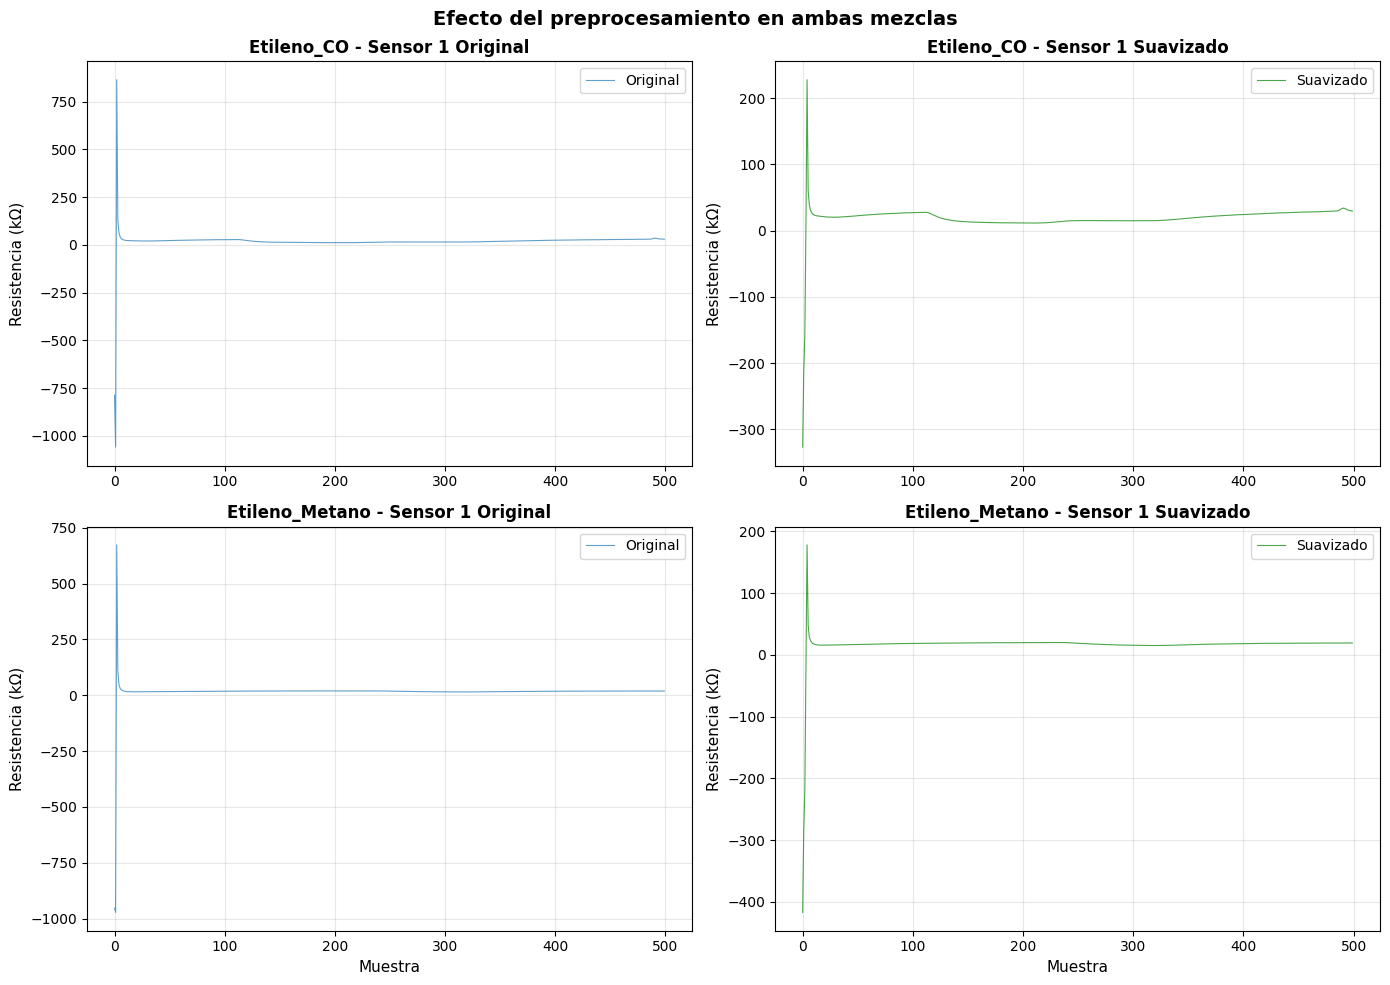

In [9]:
print("\n[3] PREPROCESAMIENTO")
print("="*80)

for mixture_name, data in data_all.items():
    df = data['df']
    
    print(f"\n📝 Procesando: {mixture_name}")
    print("-" * 80)
    
    # Downsampling
    df_processed = df.iloc[::PARAMS['downsample_factor']].copy().reset_index(drop=True)
    print(f"  ✓ Downsampling: {len(df):,} → {len(df_processed):,} registros")
    print(f"    Reducción: {(1 - len(df_processed)/len(df))*100:.1f}%")
    
    # Convertir sensores a kΩ
    sensor_cols = [col for col in df_processed.columns if col.startswith('Sensor_')]
    for col in sensor_cols:
        df_processed[col] = 40000 / df_processed[col]
    print(f"  ✓ Sensores convertidos a kΩ")
    
    # Suavizado
    for col in sensor_cols:
        df_processed[f'{col}_smooth'] = df_processed[col].rolling(
            window=PARAMS['window_size'], center=True, min_periods=1).mean()
    print(f"  ✓ Suavizado aplicado (ventana={PARAMS['window_size']})")
    
    # Guardar DataFrame procesado
    data_all[mixture_name]['df_processed'] = df_processed

print(f"\n✓ Preprocesamiento completado para {len(data_all)} datasets")
print("="*80)

# Visualización comparativa del efecto del preprocesamiento
print("\n  Visualización del efecto del preprocesamiento:")
fig, axes = plt.subplots(len(data_all), 2, figsize=(14, 5*len(data_all)))

if len(data_all) == 1:
    axes = axes.reshape(1, -1)

for idx, (mixture_name, data) in enumerate(data_all.items()):
    df_processed = data['df_processed']
    sensor_ejemplo = 'Sensor_1'
    n_samples = min(500, len(df_processed))
    
    # Original
    axes[idx, 0].plot(df_processed[sensor_ejemplo][:n_samples], 
                     linewidth=0.8, alpha=0.7, label='Original')
    axes[idx, 0].set_ylabel('Resistencia (kΩ)', fontsize=11)
    axes[idx, 0].set_title(f'{mixture_name} - Sensor 1 Original', fontsize=12, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Suavizado
    axes[idx, 1].plot(df_processed[f'{sensor_ejemplo}_smooth'][:n_samples], 
                     linewidth=0.8, alpha=0.7, color='green', label='Suavizado')
    axes[idx, 1].set_ylabel('Resistencia (kΩ)', fontsize=11)
    axes[idx, 1].set_title(f'{mixture_name} - Sensor 1 Suavizado', fontsize=12, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel('Muestra', fontsize=11)
axes[-1, 1].set_xlabel('Muestra', fontsize=11)

plt.suptitle('Efecto del preprocesamiento en ambas mezclas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


[4] FEATURE ENGINEERING

🔧 Creando features: Etileno_CO
--------------------------------------------------------------------------------
  ✓ Lags: 48 features
  ✓ Agregados: 128 features
  ✓ Derivadas: 16 features

  Total features creadas: 192
  Filas eliminadas por NaN: 6
  Registros finales: 42,077

🔧 Creando features: Etileno_Metano
--------------------------------------------------------------------------------
  ✓ Lags: 48 features
  ✓ Agregados: 128 features
  ✓ Derivadas: 16 features

  Total features creadas: 192
  Filas eliminadas por NaN: 5
  Registros finales: 41,781

✓ Feature engineering completado para 2 datasets

  Análisis comparativo de correlaciones:


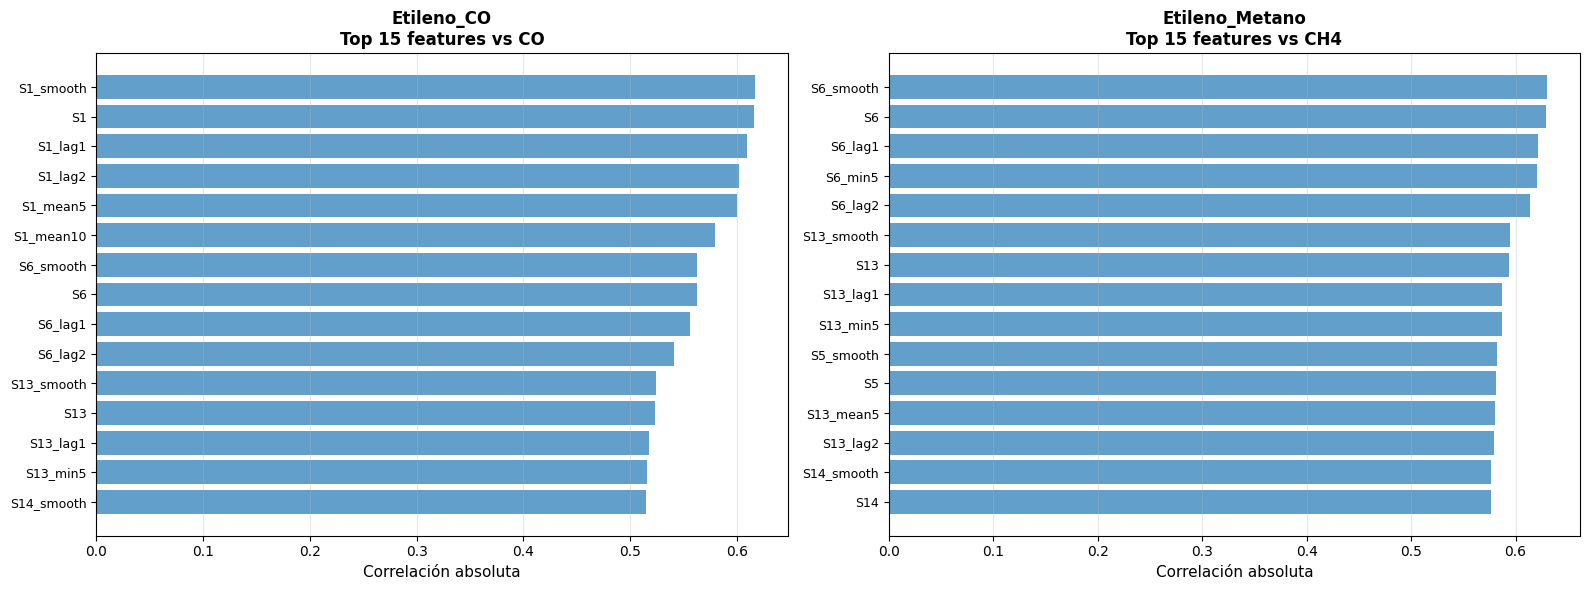

In [10]:
print("\n[4] FEATURE ENGINEERING")
print("="*80)

for mixture_name, data in data_all.items():
    df_processed = data['df_processed']
    
    print(f"\n🔧 Creando features: {mixture_name}")
    print("-" * 80)
    
    df_features = df_processed.copy()
    sensor_cols = [col for col in df_processed.columns if col.startswith('Sensor_') 
                  and not col.endswith('_smooth')]
    
    feature_count = 0
    
    # Lags
    for col in sensor_cols:
        for lag in PARAMS['lag_steps']:
            df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag)
            feature_count += 1
    print(f"  ✓ Lags: {len(sensor_cols) * len(PARAMS['lag_steps'])} features")
    
    # Agregados en ventanas
    for col in sensor_cols:
        for win in PARAMS['window_sizes']:
            df_features[f'{col}_mean{win}'] = df_features[col].rolling(window=win, min_periods=1).mean()
            df_features[f'{col}_std{win}'] = df_features[col].rolling(window=win, min_periods=1).std()
            df_features[f'{col}_max{win}'] = df_features[col].rolling(window=win, min_periods=1).max()
            df_features[f'{col}_min{win}'] = df_features[col].rolling(window=win, min_periods=1).min()
            feature_count += 4
    print(f"  ✓ Agregados: {len(sensor_cols) * len(PARAMS['window_sizes']) * 4} features")
    
    # Derivadas
    for col in sensor_cols:
        df_features[f'{col}_diff'] = df_features[col].diff()
        feature_count += 1
    print(f"  ✓ Derivadas: {len(sensor_cols)} features")
    
    # Eliminar NaN
    initial_rows = len(df_features)
    df_features = df_features.dropna()
    dropped_rows = initial_rows - len(df_features)
    
    print(f"\n  Total features creadas: {feature_count}")
    print(f"  Filas eliminadas por NaN: {dropped_rows}")
    print(f"  Registros finales: {len(df_features):,}")
    
    # Guardar
    data_all[mixture_name]['df_features'] = df_features

print(f"\n✓ Feature engineering completado para {len(data_all)} datasets")
print("="*80)

# Comparación de correlaciones entre mezclas
print("\n  Análisis comparativo de correlaciones:")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (mixture_name, data) in enumerate(data_all.items()):
    df_features = data['df_features']
    feature_cols = [col for col in df_features.columns if col.startswith('Sensor_')]
    
    # Correlación con primer gas (CO o CH4)
    correlations = df_features[feature_cols].corrwith(df_features['CO_or_CH4_ppm']).abs()
    top_features = correlations.sort_values(ascending=False).head(15)
    
    axes[idx].barh(range(len(top_features)), top_features.values, alpha=0.7)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels([f.replace('Sensor_', 'S') for f in top_features.index], fontsize=9)
    axes[idx].set_xlabel('Correlación absoluta', fontsize=11)
    axes[idx].set_title(f'{mixture_name}\nTop 15 features vs {data["info"]["gas1_name"]}', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [11]:
print("\n[5] PREPARACIÓN TRAIN/VAL/TEST")
print("="*80)

for mixture_name, data in data_all.items():
    df_features = data['df_features']
    
    print(f"\n🎯 Preparando: {mixture_name}")
    print("-" * 80)
    
    # Definir X e y
    feature_cols = [col for col in df_features.columns if col.startswith('Sensor_')]
    target_cols = ['CO_or_CH4_ppm', 'Ethylene_ppm']
    
    X = df_features[feature_cols].values
    y = df_features[target_cols].values
    
    # Split temporal
    n_samples = len(X)
    n_test = int(n_samples * PARAMS['test_size'])
    n_val = int((n_samples - n_test) * PARAMS['val_size'])
    
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]
    
    X_train, X_val = X_temp[:-n_val], X_temp[-n_val:]
    y_train, y_val = y_temp[:-n_val], y_temp[-n_val:]
    
    print(f"  Total: {n_samples:,} muestras")
    print(f"  Train: {len(X_train):,} ({len(X_train)/n_samples*100:.1f}%)")
    print(f"  Val:   {len(X_val):,} ({len(X_val)/n_samples*100:.1f}%)")
    print(f"  Test:  {len(X_test):,} ({len(X_test)/n_samples*100:.1f}%)")
    
    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"  ✓ Escalado aplicado")
    
    # Guardar
    data_all[mixture_name]['train_test'] = {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'target_cols': target_cols
    }

print(f"\n✓ Preparación completada para {len(data_all)} datasets")
print("="*80)

# Visualización comparativa de distribuciones
print("\n  Distribución de targets en conjuntos de datos:")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row_idx, (mixture_name, data) in enumerate(data_all.items()):
    tt = data['train_test']
    gas1_name = data['info']['gas1_name']
    
    # Gas 1 en train/val/test
    axes[row_idx, 0].hist(tt['y_train'][:, 0], bins=25, alpha=0.7, edgecolor='black', label='Train')
    axes[row_idx, 0].hist(tt['y_val'][:, 0], bins=25, alpha=0.7, edgecolor='black', label='Val')
    axes[row_idx, 0].hist(tt['y_test'][:, 0], bins=25, alpha=0.7, edgecolor='black', label='Test')
    axes[row_idx, 0].set_xlabel(f'{gas1_name} (ppm)', fontsize=10)
    axes[row_idx, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[row_idx, 0].set_title(f'{mixture_name} - {gas1_name}', fontsize=11, fontweight='bold')
    axes[row_idx, 0].legend()
    axes[row_idx, 0].grid(True, alpha=0.3)
    
    # Etileno en train/val/test
    axes[row_idx, 1].hist(tt['y_train'][:, 1], bins=25, alpha=0.7, edgecolor='black', label='Train')
    axes[row_idx, 1].hist(tt['y_val'][:, 1], bins=25, alpha=0.7, edgecolor='black', label='Val')
    axes[row_idx, 1].hist(tt['y_test'][:, 1], bins=25, alpha=0.7, edgecolor='black', label='Test')
    axes[row_idx, 1].set_xlabel('Etileno (ppm)', fontsize=10)
    axes[row_idx, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[row_idx, 1].set_title(f'{mixture_name} - Etileno', fontsize=11, fontweight='bold')
    axes[row_idx, 1].legend()
    axes[row_idx, 1].grid(True, alpha=0.3)
    
    # Scatter: Gas1 vs Etileno
    axes[row_idx, 2].scatter(tt['y_test'][:, 0], tt['y_test'][:, 1], alpha=0.5, s=10)
    axes[row_idx, 2].set_xlabel(f'{gas1_name} (ppm)', fontsize=10)
    axes[row_idx, 2].set_ylabel('Etileno (ppm)', fontsize=10)
    axes[row_idx, 2].set_title(f'{mixture_name} - Correlación', fontsize=11, fontweight='bold')
    axes[row_idx, 2].grid(True, alpha=0.3)

plt.suptitle('Distribución de concentraciones por conjunto - Comparación', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


[5] PREPARACIÓN TRAIN/VAL/TEST

🎯 Preparando: Etileno_CO
--------------------------------------------------------------------------------
  Total: 42,077 muestras
  Train: 30,296 (72.0%)
  Val:   3,366 (8.0%)
  Test:  8,415 (20.0%)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
print("\n[6] ENTRENAMIENTO DE MODELOS")
print("="*80)

# Definir modelos (común para ambos datasets)
models_dict = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=15, 
                                           random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=5,
                                                   random_state=42)
}

# Entrenar para cada dataset
for mixture_name, data in data_all.items():
    tt = data['train_test']
    
    print(f"\n🤖 Entrenando modelos: {mixture_name}")
    print("-" * 80)
    
    models_results = {}
    
    for model_name, model_base in models_dict.items():
        print(f"\n  {model_name}:")
        
        # Crear copia del modelo
        if model_name == 'Linear Regression':
            model = LinearRegression()
            model.fit(tt['X_train'], tt['y_train'])
        else:
            model = MultiOutputRegressor(model_base.__class__(**model_base.get_params()))
            model.fit(tt['X_train'], tt['y_train'])
        
        # Predecir en validación
        y_pred_val = model.predict(tt['X_val'])
        
        # Métricas
        mae = mean_absolute_error(tt['y_val'], y_pred_val)
        rmse = np.sqrt(mean_squared_error(tt['y_val'], y_pred_val))
        r2 = r2_score(tt['y_val'], y_pred_val)
        
        mae_per_target = [mean_absolute_error(tt['y_val'][:, i], y_pred_val[:, i]) 
                         for i in range(tt['y_val'].shape[1])]
        r2_per_target = [r2_score(tt['y_val'][:, i], y_pred_val[:, i])
                        for i in range(tt['y_val'].shape[1])]
        
        print(f"    MAE: {mae:.4f} ppm, RMSE: {rmse:.4f} ppm, R²: {r2:.4f}")
        print(f"    Por gas: MAE={[f'{m:.4f}' for m in mae_per_target]}, R²={[f'{r:.4f}' for r in r2_per_target]}")
        
        # Guardar
        models_results[model_name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mae_per_target': mae_per_target,
            'r2_per_target': r2_per_target
        }
    
    # Guardar resultados
    data_all[mixture_name]['models_results'] = models_results
    
    # Mejor modelo
    best_model_name = min(models_results.keys(), key=lambda k: models_results[k]['mae'])
    print(f"\n  ✓ Mejor modelo: {best_model_name} (MAE={models_results[best_model_name]['mae']:.4f} ppm)")

print(f"\n✓ Entrenamiento completado para {len(data_all)} datasets")
print("="*80)

# Comparación visual de modelos
print("\n  Comparación de rendimiento entre mezclas:")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE
ax = axes[0]
x = np.arange(len(models_dict))
width = 0.35

for idx, (mixture_name, data) in enumerate(data_all.items()):
    models_results = data['models_results']
    mae_values = [models_results[name]['mae'] for name in models_dict.keys()]
    ax.bar(x + idx*width, mae_values, width, label=mixture_name, alpha=0.8)

ax.set_xlabel('Modelo', fontsize=11)
ax.set_ylabel('MAE (ppm)', fontsize=11)
ax.set_title('Comparación de MAE por modelo y mezcla', fontsize=12, fontweight='bold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models_dict.keys(), rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# R²
ax = axes[1]
for idx, (mixture_name, data) in enumerate(data_all.items()):
    models_results = data['models_results']
    r2_values = [models_results[name]['r2'] for name in models_dict.keys()]
    ax.bar(x + idx*width, r2_values, width, label=mixture_name, alpha=0.8)

ax.set_xlabel('Modelo', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title('Comparación de R² por modelo y mezcla', fontsize=12, fontweight='bold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models_dict.keys(), rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
print("\n[7] EVALUACIÓN EN TEST")
print("="*80)

for mixture_name, data in data_all.items():
    tt = data['train_test']
    models_results = data['models_results']
    gas1_name = data['info']['gas1_name']
    
    print(f"\n📊 Evaluando: {mixture_name}")
    print("-" * 80)
    
    # Mejor modelo
    best_model_name = min(models_results.keys(), key=lambda k: models_results[k]['mae'])
    best_model = models_results[best_model_name]['model']
    
    print(f"  Mejor modelo: {best_model_name}")
    
    # Predecir en test
    y_pred_test = best_model.predict(tt['X_test'])
    
    # Métricas globales
    mae_test = mean_absolute_error(tt['y_test'], y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(tt['y_test'], y_pred_test))
    r2_test = r2_score(tt['y_test'], y_pred_test)
    
    print(f"  MAE: {mae_test:.4f} ppm | RMSE: {rmse_test:.4f} ppm | R²: {r2_test:.4f}")
    
    # Métricas por gas
    mae_per_target = [mean_absolute_error(tt['y_test'][:, i], y_pred_test[:, i]) 
                     for i in range(tt['y_test'].shape[1])]
    r2_per_target = [r2_score(tt['y_test'][:, i], y_pred_test[:, i])
                    for i in range(tt['y_test'].shape[1])]
    
    print(f"\n  Por gas:")
    print(f"    {gas1_name:8s}: MAE={mae_per_target[0]:.4f} ppm, R²={r2_per_target[0]:.4f}")
    print(f"    Etileno : MAE={mae_per_target[1]:.4f} ppm, R²={r2_per_target[1]:.4f}")
    
    # MAE normalizado
    ranges = [tt['y_test'][:, i].max() - tt['y_test'][:, i].min() for i in range(tt['y_test'].shape[1])]
    mae_norm = [(mae_per_target[i] / ranges[i]) * 100 if ranges[i] > 0 else 0 for i in range(len(ranges))]
    
    print(f"\n  MAE normalizado (% del rango):")
    for i, name in enumerate([gas1_name, 'Etileno']):
        cumple_h1 = "✓" if mae_norm[i] < 5 else "✗"
        print(f"    {name:8s}: {mae_norm[i]:.2f}% {cumple_h1} {'(Cumple H1)' if mae_norm[i] < 5 else '(No cumple H1)'}")
    
    # Guardar resultados de test
    data_all[mixture_name]['test_results'] = {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'y_pred': y_pred_test,
        'mae': mae_test,
        'rmse': rmse_test,
        'r2': r2_test,
        'mae_per_target': mae_per_target,
        'r2_per_target': r2_per_target,
        'mae_normalized': mae_norm
    }

print(f"\n✓ Evaluación completada para {len(data_all)} datasets")
print("="*80)

# Visualización comparativa de predicciones
print("\n  Predicciones vs Real - Comparación:")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for row_idx, (mixture_name, data) in enumerate(data_all.items()):
    tt = data['train_test']
    test_res = data['test_results']
    gas1_name = data['info']['gas1_name']
    
    # Gas 1
    axes[row_idx, 0].scatter(tt['y_test'][:, 0], test_res['y_pred'][:, 0], alpha=0.5, s=15)
    axes[row_idx, 0].plot([tt['y_test'][:, 0].min(), tt['y_test'][:, 0].max()],
                         [tt['y_test'][:, 0].min(), tt['y_test'][:, 0].max()],
                         'r--', linewidth=2, label='Perfecto')
    axes[row_idx, 0].set_xlabel(f'{gas1_name} Real (ppm)', fontsize=11)
    axes[row_idx, 0].set_ylabel(f'{gas1_name} Predicho (ppm)', fontsize=11)
    axes[row_idx, 0].set_title(f'{mixture_name} - {gas1_name}\nR²={test_res["r2_per_target"][0]:.4f}, MAE={test_res["mae_per_target"][0]:.2f} ppm',
                              fontsize=11, fontweight='bold')
    axes[row_idx, 0].legend()
    axes[row_idx, 0].grid(True, alpha=0.3)
    
    # Etileno
    axes[row_idx, 1].scatter(tt['y_test'][:, 1], test_res['y_pred'][:, 1], alpha=0.5, s=15, color='orange')
    axes[row_idx, 1].plot([tt['y_test'][:, 1].min(), tt['y_test'][:, 1].max()],
                         [tt['y_test'][:, 1].min(), tt['y_test'][:, 1].max()],
                         'r--', linewidth=2, label='Perfecto')
    axes[row_idx, 1].set_xlabel('Etileno Real (ppm)', fontsize=11)
    axes[row_idx, 1].set_ylabel('Etileno Predicho (ppm)', fontsize=11)
    axes[row_idx, 1].set_title(f'{mixture_name} - Etileno\nR²={test_res["r2_per_target"][1]:.4f}, MAE={test_res["mae_per_target"][1]:.2f} ppm',
                              fontsize=11, fontweight='bold')
    axes[row_idx, 1].legend()
    axes[row_idx, 1].grid(True, alpha=0.3)

plt.suptitle(f'Predicciones vs Real - {test_res["best_model_name"]}', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Tabla resumen comparativa
print("\n  📋 TABLA RESUMEN COMPARATIVA:")
print("  " + "="*80)
print(f"  {'Mezcla':<20} {'Mejor Modelo':<20} {'MAE':<12} {'RMSE':<12} {'R²':<8}")
print("  " + "-"*80)
for mixture_name, data in data_all.items():
    test_res = data['test_results']
    print(f"  {mixture_name:<20} {test_res['best_model_name']:<20} "
          f"{test_res['mae']:<12.4f} {test_res['rmse']:<12.4f} {test_res['r2']:<8.4f}")
print("  " + "="*80)

In [ ]:
print("\n[8] DETECCIÓN DE ANOMALÍAS")
print("="*80)

for mixture_name, data in data_all.items():
    tt = data['train_test']
    test_res = data['test_results']
    df_features = data['df_features']
    
    print(f"\n🔍 Analizando anomalías: {mixture_name}")
    print("-" * 80)
    
    # Calcular residuales
    residuals = tt['y_test'] - test_res['y_pred']
    
    # Reglas de señal
    n_test = len(tt['y_test'])
    test_indices = range(len(df_features) - n_test, len(df_features))
    df_test = df_features.iloc[test_indices].reset_index(drop=True)
    
    sensor_cols_raw = [col for col in df_test.columns 
                      if col.startswith('Sensor_') and not any(x in col for x in 
                      ['smooth', 'lag', 'mean', 'std', 'max', 'min', 'diff'])]
    
    # Flatlines
    flatlines = sum(1 for col in sensor_cols_raw 
                   if (df_test[col].diff().abs() < 0.01).sum() / len(df_test) > 0.95)
    
    # Saturación
    saturations = sum(1 for col in sensor_cols_raw 
                     if (df_test[col] > df_test[col].max() * 0.98).sum() / len(df_test) > 0.1)
    
    print(f"  Reglas de señal:")
    print(f"    Flatlines: {flatlines}/{len(sensor_cols_raw)} sensores")
    print(f"    Saturaciones: {saturations}/{len(sensor_cols_raw)} sensores")
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=PARAMS['contamination'], random_state=42)
    anomaly_labels = iso_forest.fit_predict(residuals)
    n_anomalies = (anomaly_labels == -1).sum()
    
    print(f"\n  Isolation Forest:")
    print(f"    Anomalías detectadas: {n_anomalies} ({n_anomalies/len(anomaly_labels)*100:.2f}%)")
    
    # Estadísticas de residuales
    print(f"\n  Estadísticas de residuales:")
    for i, name in enumerate([data['info']['gas1_name'], 'Etileno']):
        print(f"    {name:8s}: μ={residuals[:, i].mean():.4f}, σ={residuals[:, i].std():.4f}, "
              f"max_abs={np.abs(residuals[:, i]).max():.4f} ppm")
    
    # Guardar resultados
    data_all[mixture_name]['anomaly_results'] = {
        'flatlines': flatlines,
        'saturations': saturations,
        'n_anomalies': n_anomalies,
        'anomaly_labels': anomaly_labels,
        'residuals': residuals
    }

print(f"\n✓ Detección de anomalías completada para {len(data_all)} datasets")
print("="*80)

# Visualización comparativa de residuales
print("\n  Distribución de residuales - Comparación:")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for row_idx, (mixture_name, data) in enumerate(data_all.items()):
    anomaly_res = data['anomaly_results']
    residuals = anomaly_res['residuals']
    gas1_name = data['info']['gas1_name']
    
    # Gas 1
    axes[row_idx, 0].hist(residuals[:, 0], bins=50, alpha=0.7, edgecolor='black')
    axes[row_idx, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Cero')
    axes[row_idx, 0].set_xlabel(f'Residual {gas1_name} (ppm)', fontsize=11)
    axes[row_idx, 0].set_ylabel('Frecuencia', fontsize=11)
    axes[row_idx, 0].set_title(f'{mixture_name} - {gas1_name}\nμ={residuals[:, 0].mean():.4f}, σ={residuals[:, 0].std():.4f}',
                              fontsize=11, fontweight='bold')
    axes[row_idx, 0].legend()
    axes[row_idx, 0].grid(True, alpha=0.3)
    
    # Etileno
    axes[row_idx, 1].hist(residuals[:, 1], bins=50, alpha=0.7, edgecolor='black', color='orange')
    axes[row_idx, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Cero')
    axes[row_idx, 1].set_xlabel('Residual Etileno (ppm)', fontsize=11)
    axes[row_idx, 1].set_ylabel('Frecuencia', fontsize=11)
    axes[row_idx, 1].set_title(f'{mixture_name} - Etileno\nμ={residuals[:, 1].mean():.4f}, σ={residuals[:, 1].std():.4f}',
                              fontsize=11, fontweight='bold')
    axes[row_idx, 1].legend()
    axes[row_idx, 1].grid(True, alpha=0.3)

plt.suptitle('Distribución de residuales - Comparación de mezclas', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualización de anomalías detectadas
print("\n  Anomalías detectadas (Isolation Forest):")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (mixture_name, data) in enumerate(data_all.items()):
    tt = data['train_test']
    test_res = data['test_results']
    anomaly_res = data['anomaly_results']
    
    normal_mask = anomaly_res['anomaly_labels'] == 1
    anomaly_mask = anomaly_res['anomaly_labels'] == -1
    
    axes[idx].scatter(test_res['y_pred'][normal_mask, 0], test_res['y_pred'][normal_mask, 1],
                     alpha=0.5, s=15, label='Normal')
    axes[idx].scatter(test_res['y_pred'][anomaly_mask, 0], test_res['y_pred'][anomaly_mask, 1],
                     alpha=0.7, s=25, color='red', label=f'Anomalía ({anomaly_res["n_anomalies"]})')
    axes[idx].set_xlabel(f'{data["info"]["gas1_name"]} Predicho (ppm)', fontsize=11)
    axes[idx].set_ylabel('Etileno Predicho (ppm)', fontsize=11)
    axes[idx].set_title(f'{mixture_name}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Anomalías detectadas en predicciones', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("\n[9] PRUEBAS DE ROBUSTEZ")
print("="*80)

for mixture_name, data in data_all.items():
    tt = data['train_test']
    test_res = data['test_results']
    best_model = test_res['best_model']
    baseline_mae = test_res['mae']
    
    print(f"\n💪 Probando robustez: {mixture_name}")
    print("-" * 80)
    print(f"  MAE baseline (sin fallos): {baseline_mae:.4f} ppm")
    
    robustness_results = []
    
    for failure_rate in PARAMS['failure_rates']:
        maes = []
        
        for trial in range(PARAMS['n_trials']):
            X_test_failed = tt['X_test'].copy()
            n_features = tt['X_test'].shape[1]
            n_failures = int(n_features * failure_rate)
            failed_indices = np.random.choice(n_features, n_failures, replace=False)
            X_test_failed[:, failed_indices] = 0
            
            y_pred_failed = best_model.predict(X_test_failed)
            mae_failed = mean_absolute_error(tt['y_test'], y_pred_failed)
            maes.append(mae_failed)
        
        mean_mae = np.mean(maes)
        std_mae = np.std(maes)
        degradation = ((mean_mae - baseline_mae) / baseline_mae) * 100
        
        print(f"    Fallo {failure_rate*100:.0f}%: MAE={mean_mae:.4f}±{std_mae:.4f} ppm, Degradación={degradation:+.2f}%")
        
        robustness_results.append({
            'failure_rate': failure_rate,
            'mean_mae': mean_mae,
            'std_mae': std_mae,
            'degradation_pct': degradation
        })
    
    data_all[mixture_name]['robustness_results'] = robustness_results

print(f"\n✓ Pruebas de robustez completadas para {len(data_all)} datasets")
print("="*80)

# Visualización comparativa de robustez
print("\n  Comparación de robustez entre mezclas:")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: MAE vs Tasa de fallo
ax = axes[0]
for mixture_name, data in data_all.items():
    test_res = data['test_results']
    robustness_results = data['robustness_results']
    
    failure_rates_pct = [r['failure_rate']*100 for r in robustness_results]
    mean_maes = [r['mean_mae'] for r in robustness_results]
    std_maes = [r['std_mae'] for r in robustness_results]
    
    ax.errorbar(failure_rates_pct, mean_maes, yerr=std_maes,
               marker='o', markersize=8, capsize=5, linewidth=2,
               label=f'{mixture_name} (baseline={test_res["mae"]:.2f})')
    
ax.set_xlabel('Tasa de fallo de sensores (%)', fontsize=12)
ax.set_ylabel('MAE (ppm)', fontsize=12)
ax.set_title('Robustez ante fallos - MAE', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Gráfica 2: Degradación porcentual
ax = axes[1]
for mixture_name, data in data_all.items():
    robustness_results = data['robustness_results']
    
    failure_rates_pct = [r['failure_rate']*100 for r in robustness_results]
    degradations = [r['degradation_pct'] for r in robustness_results]
    
    ax.plot(failure_rates_pct, degradations,
           marker='o', markersize=8, linewidth=2, label=mixture_name)

ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Sin degradación')
ax.set_xlabel('Tasa de fallo de sensores (%)', fontsize=12)
ax.set_ylabel('Degradación del MAE (%)', fontsize=12)
ax.set_title('Robustez ante fallos - Degradación', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa de robustez
print("\n  📋 TABLA COMPARATIVA DE ROBUSTEZ:")
print("  " + "="*90)
print(f"  {'Mezcla':<20} {'Tasa Fallo':<12} {'MAE':<15} {'Degradación':<15} {'CV':<10}")
print("  " + "-"*90)

for mixture_name, data in data_all.items():
    robustness_results = data['robustness_results']
    for result in robustness_results:
        cv = (result['std_mae'] / result['mean_mae']) * 100
        print(f"  {mixture_name:<20} {result['failure_rate']*100:>5.0f}%       "
              f"{result['mean_mae']:>6.4f}±{result['std_mae']:.4f}  "
              f"{result['degradation_pct']:>+7.2f}%       "
              f"{cv:>6.2f}%")
    print("  " + "-"*90)

print("  " + "="*90)

# Análisis de hipótesis H4
print("\n  📊 ANÁLISIS DE HIPÓTESIS H4:")
print("  " + "-"*80)
print("  Hipótesis: Agregación mejora robustez ≥15% reducción de variabilidad")
print()
for mixture_name, data in data_all.items():
    robustness_results = data['robustness_results']
    avg_cv = np.mean([r['std_mae'] / r['mean_mae'] * 100 for r in robustness_results])
    max_degradation = max([r['degradation_pct'] for r in robustness_results])
    
    print(f"  {mixture_name}:")
    print(f"    CV promedio: {avg_cv:.2f}%")
    print(f"    Degradación máxima: {max_degradation:.2f}%")
    print(f"    Robustez: {'✓ Buena' if max_degradation < 30 else '⚠ Moderada'} (degradación < 30%)")
    print()
